In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from imgaug import augmenters as iaa
from tqdm import tqdm_notebook as tqdm
import json
import copy
import mmcv
import sys
import skimage.io as io
from pycocotools.coco import COCO   # 载入 cocoz
%matplotlib inline
import random
from PIL import Image
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [ ]:
datadir = "./data/train/images"
labeldir = "./data/train/labelTxt"
imgs = os.listdir(datadir)

In [21]:
img_id = 5
img_path = os.path.join(datadir, imgs[img_id])
img = cv2.imread(img_path)
H,W,_ = img.shape
label_path = os.path.join(labeldir, imgs[img_id].split(".")[0]+".txt")
fp = open(label_path).readlines()[4:]
print(H, W)
if(max(H, W) >3000):
    print(img_id)
    masks = []
    labels = []
    boxes = []
    for line in fp:
            line = line.strip()
            if not line:
                continue
            items = line.split(' ')
            loc = [float(x) for x in items[:8]]
            xs = loc[0::2]
            ys = loc[1::2]
            poly = np.array([[[loc[0],loc[1]],[loc[2],loc[3]],[loc[4],loc[5]],[loc[6], loc[7]]]], np.int32)
            area = cv2.contourArea(poly)
            xmin  = min(xs)
            xmax = max(xs)
            ymin = min(ys)
            ymax = max(ys)
            w = xmax - xmin
            h = ymax - ymin
            cls = items[8]
            labels.append(cls)
            masks.append(loc)
            boxes.append([xmin,ymin,xmax,ymax])
    fchips, masks, boxes, labels = _pygenerate(boxes, masks, labels, W, H, 3000, 500)

5164 6469
5


In [70]:
def get_info(fp):
    masks = []
    labels = []
    boxes = []
    for line in fp:
        line = line.strip()
        if not line:
            continue
        items = line.split(' ')
        loc = [float(x) for x in items[:8]]
        xs = loc[0::2]
        ys = loc[1::2]
        poly = np.array([[[loc[0],loc[1]],[loc[2],loc[3]],[loc[4],loc[5]],[loc[6], loc[7]]]], np.int32)
        area = cv2.contourArea(poly)
        xmin  = min(xs)
        xmax = max(xs)
        ymin = min(ys)
        ymax = max(ys)
        w = xmax - xmin
        h = ymax - ymin
        cls = items[8]
        if cls not in CLASS:
            continue
        labels.append(cls)
        masks.append(loc)
        boxes.append([xmin,ymin,xmax,ymax])
    return labels, masks, boxes

def gen_ann(box, mask, label, annotations, obj_id, ID, xmin, ymin):
    for b, loc, l in zip(box, mask, label):
        x1, y1, x2, y2 = b
        x1 -= xmin
        y1 -= ymin
        x2 -= xmin
        y2 -= ymin
        poly = np.array([[[loc[0],loc[1]],[loc[2],loc[3]],[loc[4],loc[5]],[loc[6], loc[7]]]], np.int32)
        box = [x1, y1, x2, y2]
        area = cv2.contourArea(poly)
        poly = [loc[0]-xmin,loc[1]-ymin,loc[2]-xmin,loc[3]-ymin,loc[4]-xmin,loc[5]-ymin,loc[6]-xmin, loc[7]-ymin]
        annotation = {"id" : obj_id, 
                "image_id" : ID, 
                "category_id" : class_to_ind[l], 
                "segmentation" : [poly], 
               "area" :  area, 
               "bbox" : [x1, y1, x2-x1, y2-y1], 
               "iscrowd" : 0,
            }
        obj_id += 1
        annotations["annotations"].append(annotation)
    ID += 1
    return annotations, obj_id, ID
  #         poly = np.array([[[loc[0],loc[1]],[loc[2],loc[3]],[loc[4],loc[5]],[loc[6], loc[7]]]], np.int32)
            #         img2 = cv2.polylines(img2, poly, 1,(0,255,0), 1)
                    #cv2.rectangle(img2 , (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)
            #         poly = np.array([[[loc[0]-xmin,loc[1]-ymin],[loc[2]-xmin,loc[3]-ymin],[loc[4]-xmin,loc[5]-ymin],[loc[6]-xmin, loc[7]-ymin]]], np.int32)
            #         cv2.polylines(img2, poly, 1,(0,255,0), 2)
            #         cv2.fillPoly(img2, poly, 255)

In [39]:
def bbox_overlaps_py(boxes, query_boxes):
    """
    determine overlaps between boxes and query_boxes
    :param boxes: n * 4 bounding boxes
    :param query_boxes: k * 4 bounding boxes
    :return: overlaps: n * k overlaps
    """
    n_ = boxes.shape[0]
    k_ = query_boxes.shape[0]
    overlaps = np.zeros((n_, k_), dtype=np.float)
    for k in range(k_):
        query_box_area = (query_boxes[k, 2] - query_boxes[k, 0] + 1) * (query_boxes[k, 3] - query_boxes[k, 1] + 1)
        for n in range(n_):
            iw = min(boxes[n, 2], query_boxes[k, 2]) - max(boxes[n, 0], query_boxes[k, 0]) + 1
            if iw > 0:
                ih = min(boxes[n, 3], query_boxes[k, 3]) - max(boxes[n, 1], query_boxes[k, 1]) + 1
                if ih > 0:
                    box_area = (boxes[n, 2] - boxes[n, 0] + 1) * (boxes[n, 3] - boxes[n, 1] + 1)
                    all_area = float(query_box_area)
                    overlaps[n, k] = iw * ih / all_area
    return overlaps

def _pygenerate(boxes, masks, labels, width, height, chipsize, stride):
        chips = []
        boxes = np.array(boxes)
        masks = np.array(masks)
        # ensure coverage of image for worst case
        # corners
        chips.append([max(width - chipsize, 0), 0, width - 1, min(chipsize, height-1)])
        chips.append([0, max(height - chipsize, 0), min(chipsize, width-1), height-1])
        chips.append([max(width - chipsize, 0), max(height - chipsize, 0), width-1, height-1])
		
        for i in range(0, width - int(chipsize), stride):
            for j in range(0, height - int(chipsize), stride):
                x1 = i
                y1 = j
                x2 = i + chipsize - 1
                y2 = j + chipsize - 1
                chips.append([x1, y1, x2, y2])
		#width may not be divide by stride
        for j in range(0, height - int(chipsize), stride):
            x1 = max(width - chipsize - 1,0)
            y1 = j
            x2 = width - 1
            y2 = j + chipsize - 1
            chips.append([x1, y1, x2, y2])
		#the same as above
        for i in range(0, width - int(chipsize), stride):
            x1 = i
            y1 = max(height - chipsize - 1,0)
            x2 = i + chipsize - 1
            y2 = height - 1
            chips.append([x1, y1, x2, y2])

        chips = np.array(chips).astype(np.float)
        overlaps = bbox_overlaps_py(chips, boxes.astype(np.float))
        fchips = []
        masks_list = []
        boxes_list = []
        labels_list = []
        for j in range(len(chips)):
            nvids = np.where(overlaps[j, :] >= 0.9)[0]
            if(len(nvids) == 0):
                continue
            else:
                fchips.append(chips[j])
                boxes_list.append(boxes[nvids])
                masks_list.append(masks[nvids])
                labels_list.append([labels[x] for x in nvids])
        return fchips, masks_list, boxes_list, labels_list

def test_pygenerate(width, height, chipsize, stride):
        chips = []
        # ensure coverage of image for worst case
        # corners
        chips.append([max(width - chipsize, 0), 0, width - 1, min(chipsize, height-1)])
        chips.append([0, max(height - chipsize, 0), min(chipsize, width-1), height-1])
        chips.append([max(width - chipsize, 0), max(height - chipsize, 0), width-1, height-1])
		
        for i in range(0, width - int(chipsize), stride):
            for j in range(0, height - int(chipsize), stride):
                x1 = i
                y1 = j
                x2 = i + chipsize - 1
                y2 = j + chipsize - 1
                chips.append([x1, y1, x2, y2])
		#width may not be divide by stride
        for j in range(0, height - int(chipsize), stride):
            x1 = max(width - chipsize - 1,0)
            y1 = j
            x2 = width - 1
            y2 = j + chipsize - 1
            chips.append([x1, y1, x2, y2])
		#the same as above
        for i in range(0, width - int(chipsize), stride):
            x1 = i
            y1 = max(height - chipsize - 1,0)
            x2 = i + chipsize - 1
            y2 = height - 1
            chips.append([x1, y1, x2, y2])

        chips = np.array(chips).astype(np.float)
        return chips
def generate_test(datdir, phase):
    info = {
        "description": "rscup",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2014,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
      }
    license = [{ "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/", "id": 1, "name": "Attribution-NonCommercial-ShareAlike License"} ]
    categories = []
    for cls in CLASS:
        category = { "id" : class_to_ind[cls], "name" : cls, "supercategory" : "object",}
        categories.append(category)

    annotations = {"info": info, "images": [], "annotations": [], "categories":categories, "license":license}
    imgs = os.listdir(datadir)
    ID = 0
    for img_id in tqdm(range(len(imgs))):
        img_path = os.path.join(datadir, imgs[img_id])
        img = cv2.imread(img_path)
        H,W,_ = img.shape
        if max(H,W) > 512:
            fchips = test_pygenerate(W, H, 512, 416)
            count = 0
            for chip in fchips:
                count+=1
                xmin, ymin, xmax, ymax = chip
                filename = imgs[img_id].split(".")[0] + "_{}_{}_".format(str(xmin), str(ymin))+"_part" +str(count) + ".jpg"
                image = { "license": 1,
                          "file_name": filename,
                          "coco_url": "xxx",
                          "height": ymax-ymin,
                          "width": xmax-xmin,
                          "date_captured": "2019-06-25",
                          "flickr_url": "xxx",
                          "id": ID
                        }
                ID += 1
                annotations["images"].append(image)
                img2 = copy.deepcopy(img[int(ymin):int(ymax), int(xmin):int(xmax),:])
                cv2.imwrite("./rscup/{}/".format(phase)+filename, img2)
        else:
            filename = imgs[img_id].split(".")[0] + "_{}_{}_".format(str(0), str(0))+"_part" +str(0) + ".jpg"
            image = { "license": 1,
                          "file_name": filename,
                          "coco_url": "xxx",
                          "height": H,
                          "width": W,
                          "date_captured": "2019-06-25",
                          "flickr_url": "xxx",
                          "id": ID
                        }
            ID += 1
            annotations["images"].append(image)
            cv2.imwrite("./rscup/{}/".format(phase)+filename, img)
    with open('./rscup/annotation/annos_rscup_'+phase+'.json', 'w') as json_file:
        json.dump(annotations, json_file, cls=MyEncoder)
        
def generate_anno(filename, height, width, ID):
    image = { "license": 1,
              "file_name": filename,
              "coco_url": "xxx",
              "height": height,
              "width": width,
              "date_captured": "2019-06-25",
              "flickr_url": "xxx",
              "id": ID
            }
    return image
        
def scale_generate_test(datdir, phase, SCALE):
    imgs = os.listdir(datadir)
    rotate90 = iaa.Sequential(
    [iaa.Affine(rotate=90)])
    rotate090 = iaa.Sequential(
    [iaa.Affine(rotate=-90)])
    info = {
        "description": "rscup",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2014,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
      }
    license = [{ "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/", "id": 1, "name": "Attribution-NonCommercial-ShareAlike License"} ]
    categories = []
    for cls in CLASS:
        category = { "id" : class_to_ind[cls], "name" : cls, "supercategory" : "object",}
        categories.append(category)
    print(categories)
    annotations = {"info": info, "images": [], "annotations": [], "categories":categories, "license":license}
    obj_id = 0
    ID = 0
    for img_id in tqdm(range(len(imgs))):
        img_path = os.path.join(datadir, imgs[img_id])
        original_img = cv2.imread(img_path)
        h, w, _ = original_img.shape
        scales = copy.deepcopy(SCALE)
#         if(max(h, w) > 10000):
#             scales.append(0.1)
        for scale in scales:
            img, scale_factor = mmcv.imrescale(original_img, scale, return_scale=True)
            H,W,_ = img.shape
            if max(H,W) > 512:
                fchips = test_pygenerate(W, H, 512, 416)
                count = 0
                for chip in  fchips:
                    count+=1
                    xmin, ymin, xmax, ymax = chip
                    img2 = copy.deepcopy(img[int(ymin):int(ymax), int(xmin):int(xmax),:])
                    hh, ww, _ = img2.shape
                    filename = imgs[img_id].split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(xmin), str(ymin), str(0))+"part" +str(count) + ".jpg"
                    cv2.imwrite("./rscup/{}/".format(phase)+filename, img2)
                    image = generate_anno(filename, hh, ww, ID)
                    annotations["images"].append(image)
                    ID += 1
                    
#                     filename = imgs[img_id].split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(xmin), str(ymin), str(90))+"part" +str(count) + ".jpg"
#                     img_rotate90 = rotate90.augment_image(img2)
#                     cv2.imwrite("./rscup/{}/".format(phase)+filename, img_rotate90)
#                     image = generate_anno(filename, hh, ww, ID)
#                     annotations["images"].append(image)
#                     ID += 1
                    
#                     filename = imgs[img_id].split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(xmin), str(ymin), str(-90))+"part" +str(count) + ".jpg"
#                     img_rotate090 = rotate090.augment_image(img2)
#                     cv2.imwrite("./rscup/{}/".format(phase)+filename, img_rotate090)
#                     image = generate_anno(filename, hh, ww, ID)
#                     annotations["images"].append(image)
#                     ID += 1     
            else:
                filename = imgs[img_id].split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(0), str(0), str(0))+"part" +str(0) + ".jpg"
                image = generate_anno(filename, H, W, ID)
                annotations["images"].append(image)
                ID += 1
                cv2.imwrite("./rscup/{}/".format(phase)+filename, img)
                
#                 img_rotate90 = rotate90.augment_image(img)
#                 filename = imgs[img_id].split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(0), str(0), str(90))+"part" +str(0) + ".jpg"
#                 image = generate_anno(filename, H, W, ID)
#                 annotations["images"].append(image)
#                 ID += 1
#                 cv2.imwrite("./rscup/{}/".format(phase)+filename, img_rotate90)
                
#                 img_rotate090 = rotate090.augment_image(img)
#                 filename = imgs[img_id].split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(0), str(0), str(-90))+"part" +str(0) + ".jpg"
#                 image = generate_anno(filename,H,W, ID)
#                 annotations["images"].append(image)
#                 ID += 1
#                 cv2.imwrite("./rscup/{}/".format(phase)+filename, img_rotate090)
                
    with open('./rscup/annotation/annos_rscup_'+phase+'.json', 'w') as json_file:
        json.dump(annotations, json_file, cls=MyEncoder)
    print("totol number {}".format(str(ID)))

    
def increment_generate(datdir, phase):
    imgs = os.listdir(datadir)
    coco=COCO('./rscup/annotation/annos_rscup_'+phase+'.json')
    annotations = mmcv.load('./rscup/annotation/annos_rscup_'+phase+'.json')
    imgids = coco.getImgIds()
    ID = max(imgids)+1
    for img_id in tqdm(range(len(imgs))):
        img_path = os.path.join(datadir, imgs[img_id])
        original_img = cv2.imread(img_path)
        h, w, _ = original_img.shape
        scale_factor = 512 /  max(h, w)
        img, scale_factor = mmcv.imrescale(original_img, scale_factor, return_scale=True)
        H,W,_ = img.shape
        filename = imgs[img_id].split(".")[0] + "_{}_{}_{}_{}".format(str(scale_factor), str(0), str(0), str(0))+"part" +str(0) + ".jpg"
        image = { "license": 1,
                          "file_name": filename,
                          "coco_url": "xxx",
                          "height": H,
                          "width": W,
                          "date_captured": "2019-06-25",
                          "flickr_url": "xxx",
                          "id": ID
                        }
        ID += 1
        cv2.imwrite("./rscup/{}/".format(phase)+filename, img)
        annotations["images"].append(image)
        
    with open('./rscup/annotation/annos_rscup_'+phase+'.json', 'w') as json_file:
        json.dump(annotations, json_file, cls=MyEncoder)
    print("totol number {}".format(str(ID)))    
    
    

def generate_nopatch(datdir, labeldir, phase):
    imgs = os.listdir(datadir)
    info = {
        "description": "rscup",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2014,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
      }
    license = [{ "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/", "id": 1, "name": "Attribution-NonCommercial-ShareAlike License"} ]
    categories = []
    for cls in CLASS:
        category = { "id" : class_to_ind[cls], "name" : cls, "supercategory" : "object",}
        categories.append(category)

    annotations = {"info": info, "images": [], "annotations": [], "categories":categories, "license":license}
    obj_id = 0
    ID = 0
    for img_id in tqdm(range(len(imgs))):
        img_path = os.path.join(datadir, imgs[img_id])
        img = cv2.imread(img_path)
        H,W,_ = img.shape
        label_path = os.path.join(labeldir, imgs[img_id].split(".")[0]+".txt")
        fp = open(label_path).readlines()[2:]
        labels, masks, boxes = get_info(fp)
       
        filename = imgs[img_id]
        image = { "license": 1,
                      "file_name": filename,
                      "coco_url": "xxx",
                      "height": H,
                      "width": W,
                      "date_captured": "2019-06-25",
                      "flickr_url": "xxx",
                      "id": ID
                    }

        #cv2.imwrite("./rscup/{}/".format(phase)+filename, img)
        annotations["images"].append(image)
        annotations, obj_id, ID = gen_ann(boxes, masks, labels, annotations, obj_id, ID,0, 0)
    with open('./data/annotation/annos_rscup_'+phase+'.json', 'w') as json_file:
        json.dump(annotations, json_file, cls=MyEncoder)

        
def get_scale_info(fp, scale):
    masks = []
    labels = []
    boxes = []
    for line in fp:
        line = line.strip()
        if not line:
            continue
        items = line.split(' ')
        loc = np.array([float(x) for x in items[:8]])
        loc = loc*scale
        xs = loc[0::2]
        ys = loc[1::2]
        poly = np.array([[[loc[0],loc[1]],[loc[2],loc[3]],[loc[4],loc[5]],[loc[6], loc[7]]]], np.int32)
        area = cv2.contourArea(poly)
        if(area < 50):
            continue
        xmin  = min(xs)
        xmax = max(xs)
        ymin = min(ys)
        ymax = max(ys)
        w = xmax - xmin
        h = ymax - ymin
        cls = items[8]
        if cls not in CLASS:
            continue
        labels.append(cls)
        masks.append(loc)
        boxes.append([xmin,ymin,xmax,ymax])
    return labels, masks, boxes
        
def scale_generate(datdir, labeldir, phase, SCALE):
    imgs = os.listdir(datadir)
    info = {
        "description": "rscup",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2014,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
      }
    license = [{ "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/", "id": 1, "name": "Attribution-NonCommercial-ShareAlike License"} ]
    categories = []
    for cls in CLASS:
        category = { "id" : class_to_ind[cls], "name" : cls, "supercategory" : "object",}
        categories.append(category)
    print(categories)
    annotations = {"info": info, "images": [], "annotations": [], "categories":categories, "license":license}
    obj_id = 0
    ID = 0
    for img_id in tqdm(range(len(imgs))):
        img_path = os.path.join(datadir, imgs[img_id])
        label_path = os.path.join(labeldir, imgs[img_id].split(".")[0]+".txt")
        original_img = cv2.imread(img_path)
        h, w, _ = original_img.shape
        scales = copy.deepcopy(SCALE)
#         if(max(h, w) > 10000):
#             scales.append(0.1)
        fp = open(label_path).readlines()[2:]
        for scale in scales:
            img, scale_factor = mmcv.imrescale(original_img, scale, return_scale=True)
            H,W,_ = img.shape
            labels, masks, boxes = get_scale_info(fp, scale_factor)
            if(len(labels)<=0):
                continue
            if max(H,W) > 512:
                fchips, masks, boxes, labels = _pygenerate(boxes, masks, labels, W, H, 512, 416)
                count = 0
                for chip, mask, box, label in zip(fchips, masks, boxes,labels):
                    count+=1
                    xmin, ymin, xmax, ymax = chip
                    filename = imgs[img_id].split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(xmin), str(ymin), str(0))+"part" +str(count) + ".jpg"
                    img2 = copy.deepcopy(img[int(ymin):int(ymax), int(xmin):int(xmax),:])
                    cv2.imwrite("./rscup/{}/".format(phase)+filename, img2)
                    image = { "license": 1,
                              "file_name": filename,
                              "coco_url": "xxx",
                              "height": ymax-ymin,
                              "width": xmax-xmin,
                              "date_captured": "2019-06-25",
                              "flickr_url": "xxx",
                              "id": ID
                            }
                    annotations["images"].append(image)
                    annotations, obj_id, ID = gen_ann(box, mask, label, annotations, obj_id, ID, xmin, ymin)
            else:
                filename = imgs[img_id].split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(0), str(0), str(0))+"part" +str(0) + ".jpg"
                image = { "license": 1,
                              "file_name": filename,
                              "coco_url": "xxx",
                              "height": H,
                              "width": W,
                              "date_captured": "2019-06-25",
                              "flickr_url": "xxx",
                              "id": ID
                            }

                cv2.imwrite("./rscup/{}/".format(phase)+filename, img)
                annotations["images"].append(image)
                annotations, obj_id, ID = gen_ann(boxes, masks, labels, annotations, obj_id, ID,0, 0)
    with open('./rscup/annotation/annos_rscup_'+phase+'.json', 'w') as json_file:
        json.dump(annotations, json_file, cls=MyEncoder)
    print("totol number {}".format(str(ID)))
    
    
def increment_train_generate(datdir, labeldir, phase):
    imgs = os.listdir(datadir)
    imgs = os.listdir(datadir)
    coco=COCO('./rscup/annotation/annos_rscup_'+phase+'.json')
    annotations = mmcv.load('./rscup/annotation/annos_rscup_'+phase+'.json')
    imgids = coco.getImgIds()
    annids = coco.getAnnIds()
    ID = max(imgids)+1
    obj_id = max(annids)+1
    for img_id in tqdm(range(len(imgs))):
        img_path = os.path.join(datadir, imgs[img_id])
        label_path = os.path.join(labeldir, imgs[img_id].split(".")[0]+".txt")
        original_img = cv2.imread(img_path)
        h, w, _ = original_img.shape
        scale = 512 /  max(h, w)
#         if(max(h, w) > 10000):
#             scales.append(0.1)
        fp = open(label_path).readlines()[2:]
        img, scale_factor = mmcv.imrescale(original_img, scale, return_scale=True)
        H,W,_ = img.shape
        labels, masks, boxes = get_scale_info(fp, scale_factor)
        if(len(labels)<=0):
            continue
        filename = imgs[img_id].split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(0), str(0), str(0))+"part" +str(0) + ".jpg"
        image = { "license": 1,
                      "file_name": filename,
                      "coco_url": "xxx",
                      "height": H,
                      "width": W,
                      "date_captured": "2019-06-25",
                      "flickr_url": "xxx",
                      "id": ID
                    }

        cv2.imwrite("./rscup/{}/".format(phase)+filename, img)
        annotations["images"].append(image)
        annotations, obj_id, ID = gen_ann(boxes, masks, labels, annotations, obj_id, ID,0, 0)
    with open('./rscup/annotation/annos_rscup_'+phase+'.json', 'w') as json_file:
        json.dump(annotations, json_file, cls=MyEncoder)
    print("totol number {}".format(str(ID)))

In [71]:
CLASS=['tennis-court', 'container-crane', 'storage-tank', 'baseball-diamond', 'plane', 'ground-track-field', 'helicopter', 'airport', 'harbor', 'ship', 'large-vehicle', 'swimming-pool', 'soccer-ball-field', 'roundabout', 'basketball-court', 'bridge', 'small-vehicle', 'helipad']
#CLASS={'tennis-court', 'container-crane', 'storage-tank', 'baseball-diamond', 'plane', 'ground-track-field', 'helicopter', 'airport', 'harbor', 'ship', 'large-vehicle', 'swimming-pool', 'soccer-ball-field', 'roundabout', 'basketball-court', 'bridge', 'small-vehicle', 'helipad'}
class_to_ind = dict(zip(CLASS, range(len(CLASS))))
print(class_to_ind)

{'tennis-court': 0, 'container-crane': 1, 'storage-tank': 2, 'baseball-diamond': 3, 'plane': 4, 'ground-track-field': 5, 'helicopter': 6, 'airport': 7, 'harbor': 8, 'ship': 9, 'large-vehicle': 10, 'swimming-pool': 11, 'soccer-ball-field': 12, 'roundabout': 13, 'basketball-court': 14, 'bridge': 15, 'small-vehicle': 16, 'helipad': 17}


### generate train data

In [72]:
datadir = "./data/train/images"
labeldir = "./data/train/labelTxt"
scale_generate(datadir, labeldir, "train", [1, 0.5])

[{'id': 0, 'name': 'tennis-court', 'supercategory': 'object'}, {'id': 1, 'name': 'container-crane', 'supercategory': 'object'}, {'id': 2, 'name': 'storage-tank', 'supercategory': 'object'}, {'id': 3, 'name': 'baseball-diamond', 'supercategory': 'object'}, {'id': 4, 'name': 'plane', 'supercategory': 'object'}, {'id': 5, 'name': 'ground-track-field', 'supercategory': 'object'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'object'}, {'id': 7, 'name': 'airport', 'supercategory': 'object'}, {'id': 8, 'name': 'harbor', 'supercategory': 'object'}, {'id': 9, 'name': 'ship', 'supercategory': 'object'}, {'id': 10, 'name': 'large-vehicle', 'supercategory': 'object'}, {'id': 11, 'name': 'swimming-pool', 'supercategory': 'object'}, {'id': 12, 'name': 'soccer-ball-field', 'supercategory': 'object'}, {'id': 13, 'name': 'roundabout', 'supercategory': 'object'}, {'id': 14, 'name': 'basketball-court', 'supercategory': 'object'}, {'id': 15, 'name': 'bridge', 'supercategory': 'object'}, {'id': 16, 'n

totol number 45792


In [73]:
datadir = "./data/train/images"
labeldir = "./data/train/labelTxt"
increment_train_generate(datadir, labeldir, "train")

loading annotations into memory...
Done (t=4.82s)
creating index...
index created!


totol number 47507


### generate val data

In [66]:
# datadir = "./data/val/images"
# labeldir = "./data/val/labelTxt"
# scale_generate(datadir, labeldir, "val", [1])
datadir = "./data/val/images"
scale_generate_test(datadir, "val", [1])

[{'id': 0, 'name': 'tennis-court', 'supercategory': 'object'}, {'id': 1, 'name': 'container-crane', 'supercategory': 'object'}, {'id': 2, 'name': 'storage-tank', 'supercategory': 'object'}, {'id': 3, 'name': 'baseball-diamond', 'supercategory': 'object'}, {'id': 4, 'name': 'plane', 'supercategory': 'object'}, {'id': 5, 'name': 'ground-track-field', 'supercategory': 'object'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'object'}, {'id': 7, 'name': 'airport', 'supercategory': 'object'}, {'id': 8, 'name': 'harbor', 'supercategory': 'object'}, {'id': 9, 'name': 'ship', 'supercategory': 'object'}, {'id': 10, 'name': 'large-vehicle', 'supercategory': 'object'}, {'id': 11, 'name': 'swimming-pool', 'supercategory': 'object'}, {'id': 12, 'name': 'soccer-ball-field', 'supercategory': 'object'}, {'id': 13, 'name': 'roundabout', 'supercategory': 'object'}, {'id': 14, 'name': 'basketball-court', 'supercategory': 'object'}, {'id': 15, 'name': 'bridge', 'supercategory': 'object'}, {'id': 16, 'n

totol number 29057


In [68]:
increment_generate(datadir, "val")

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


totol number 29650


In [137]:
datadir = "./data/val/images"
labeldir = "./data/val/labelTxt"
generate_nopatch(datadir, labeldir, "val")

P0814.png
P1314.png
P1275.png
P0844.png
P1878.png
P1542.png
P6582.png
P4037.png
P9705.png
P0199.png
P3575.png
P4151.png
P1133.png
P1456.png
P1854.png
P1101.png
P2481.png
P2420.png
P2027.png
P3107.png
P4359.png
P6258.png
P0242.png
P1754.png
P2068.png
P0146.png
P1373.png
P2599.png
P2256.png
P4957.png
P3185.png
P1138.png
P1560.png
P2181.png
P4952.png
P7129.png
P3989.png
P0706.png
P2802.png
P2042.png
P1212.png
P2455.png
P1269.png
P0932.png
P0194.png
P1672.png
P2093.png
P2733.png
P1154.png
P1007.png
P4265.png
P1982.png
P0622.png
P2570.png
P2771.png
P0604.png
P4083.png
P1541.png
P3182.png
P4055.png
P0342.png
P1786.png
P0170.png
P2502.png
P2593.png
P2721.png
P2408.png
P1030.png
P0647.png
P9854.png
P2385.png
P4627.png
P1213.png
P0466.png
P2695.png
P0799.png
P2239.png
P1806.png
P1751.png
P2678.png
P9031.png
P2726.png
P3032.png
P1569.png
P0382.png
P1021.png
P2709.png
P1483.png
P3407.png
P1091.png
P10810.png
P0375.png
P7431.png
P1512.png
P5171.png
P9594.png
P1809.png
P2351.png
P1940.png
P1960.png

In [136]:
datadir = "./data/train/images"
labeldir = "./data/train/labelTxt"
generate_nopatch(datadir, labeldir, "train")

In [287]:
datadir = "./data/train/images"
labeldir = "./data/train/labelTxt"
generate_nopatch(datadir, labeldir, "train")

### generate test data

In [49]:
datadir = "./data/test/images"
scale_generate_test(datadir, "test", [1, 0.5])

[{'id': 0, 'name': 'tennis-court', 'supercategory': 'object'}, {'id': 1, 'name': 'container-crane', 'supercategory': 'object'}, {'id': 2, 'name': 'storage-tank', 'supercategory': 'object'}, {'id': 3, 'name': 'baseball-diamond', 'supercategory': 'object'}, {'id': 4, 'name': 'plane', 'supercategory': 'object'}, {'id': 5, 'name': 'ground-track-field', 'supercategory': 'object'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'object'}, {'id': 7, 'name': 'airport', 'supercategory': 'object'}, {'id': 8, 'name': 'harbor', 'supercategory': 'object'}, {'id': 9, 'name': 'ship', 'supercategory': 'object'}, {'id': 10, 'name': 'large-vehicle', 'supercategory': 'object'}, {'id': 11, 'name': 'swimming-pool', 'supercategory': 'object'}, {'id': 12, 'name': 'soccer-ball-field', 'supercategory': 'object'}, {'id': 13, 'name': 'roundabout', 'supercategory': 'object'}, {'id': 14, 'name': 'basketball-court', 'supercategory': 'object'}, {'id': 15, 'name': 'bridge', 'supercategory': 'object'}, {'id': 16, 'n

totol number 63607


In [50]:
datadir = "./data/test/images"
increment_generate(datadir, "test")

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


totol number 64387


In [52]:
import sys
sys.path.append('D:\API\cocoapi\PythonAPI')  # 你下载的 cocoapi 所在路径
import skimage.io as io
from pycocotools.coco import COCO   # 载入 cocoz
%matplotlib inline
coco=COCO("./rscup/annotation/annos_rscup_train.json")

loading annotations into memory...
Done (t=5.41s)
creating index...
index created!


[17]
{'license': 1, 'file_name': 'P5593_1_0.0_832.0_0part4.jpg', 'coco_url': 'xxx', 'height': 511.0, 'width': 511.0, 'date_captured': '2019-06-25', 'flickr_url': 'xxx', 'id': 26672}
7


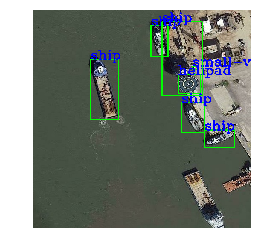

In [53]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['helipad'])
print(catIds)
imgIds = coco.getImgIds(catIds=catIds)
# imgIds = coco.getImgIds(imgIds=[335328])
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
I = io.imread('./rscup/train/'+img['file_name'])
plt.imshow(I)
plt.axis('off')
print(img)
annIds = coco.getAnnIds(imgIds=[img['id']], iscrowd=None)
print(len(annIds))
anns = coco.loadAnns(annIds)
for ann in anns:
    bbox = ann['bbox']
    x = [int(x) for x in bbox]
    cv2.rectangle(I, (x[0],x[1]), (x[0]+x[2],x[1]+x[3]), (0,255,0), 2)
    cv2.putText(I, CLASS[ann['category_id']], (x[0],x[1]), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
plt.imshow(I)
#coco.showAnns(anns)

In [307]:
def _pygenerate_noobj(boxes, masks, labels, width, height, chipsize, stride):
        chips = []
        boxes = np.array(boxes)
        masks = np.array(masks)
        # ensure coverage of image for worst case
        # corners
        chips.append([max(width - chipsize, 0), 0, width - 1, min(chipsize, height-1)])
        chips.append([0, max(height - chipsize, 0), min(chipsize, width-1), height-1])
        chips.append([max(width - chipsize, 0), max(height - chipsize, 0), width-1, height-1])
		
        for i in range(0, width - int(chipsize), stride):
            for j in range(0, height - int(chipsize), stride):
                x1 = i
                y1 = j
                x2 = i + chipsize - 1
                y2 = j + chipsize - 1
                chips.append([x1, y1, x2, y2])
		#width may not be divide by stride
        for j in range(0, height - int(chipsize), stride):
            x1 = max(width - chipsize - 1,0)
            y1 = j
            x2 = width - 1
            y2 = j + chipsize - 1
            chips.append([x1, y1, x2, y2])
		#the same as above
        for i in range(0, width - int(chipsize), stride):
            x1 = i
            y1 = max(height - chipsize - 1,0)
            x2 = i + chipsize - 1
            y2 = height - 1
            chips.append([x1, y1, x2, y2])

        chips = np.array(chips).astype(np.float)
        overlaps = bbox_overlaps_py(chips, boxes.astype(np.float))
        fchips = []
        masks_list = []
        boxes_list = []
        labels_list = []
        for j in range(len(chips)):
            nvids = np.where(overlaps[j, :] >= 0.7)[0]
            if(len(nvids) == 0):
                fchips.append(chips[j])
        return fchips
    
def scale_generate_noobj(datdir, labeldir, phase, SCALE):
    imgs = os.listdir(datadir)
    for img_id in tqdm(range(len(imgs))):
        img_path = os.path.join(datadir, imgs[img_id])
        label_path = os.path.join(labeldir, imgs[img_id].split(".")[0]+".txt")
        original_img = cv2.imread(img_path)
        h, w, _ = original_img.shape
        scales = copy.deepcopy(SCALE)
        fp = open(label_path).readlines()[2:]
        for scale in scales:
            img, scale_factor = mmcv.imrescale(original_img, scale, return_scale=True)
            H,W,_ = img.shape
            labels, masks, boxes = get_scale_info(fp, scale_factor)
            if(len(labels)<=0):
                continue
            if max(H,W) >= 512:
                fchips = _pygenerate_noobj(boxes, masks, labels, W, H, 512, 416)
                count = 0
                for chip in fchips:
                    count+=1
                    xmin, ymin, xmax, ymax = chip
                    filename = imgs[img_id].split(".")[0] + "_{}_{}_{}_".format(str(scale), str(xmin), str(ymin))+"part" +str(count) + ".jpg"
                    img2 = copy.deepcopy(img[int(ymin):int(ymax), int(xmin):int(xmax),:])
                    cv2.imwrite("./{}/".format(phase)+filename, img2)

In [308]:
datadir = "./data/train/images"
labeldir = "./data/train/labelTxt"
scale_generate_noobj(datadir, labeldir, "pre", [0.5, 1])

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


totol number 64387


In [316]:
import sys
sys.path.append('D:\API\cocoapi\PythonAPI')  # 你下载的 cocoapi 所在路径
import skimage.io as io
from pycocotools.coco import COCO   # 载入 cocoz
%matplotlib inline
coco=COCO("./data/annotation/annos_rscup_train.json")
imgids = coco.getImgIds()
curr = max(imgids)+1
print(curr)

loading annotations into memory...
Done (t=1.80s)
creating index...
index created!
14156


# aug special class

In [231]:
CLASS=['tennis-court', 'container-crane', 'storage-tank', 'baseball-diamond', 'plane', 'ground-track-field', 'helicopter', 'airport', 'harbor', 'ship', 'large-vehicle', 'swimming-pool', 'soccer-ball-field', 'roundabout', 'basketball-court', 'bridge', 'small-vehicle', 'helipad','noise']
coco=COCO("/home/xfr/rssid/data/annotation/annos_rscup_train.json")
import mmcv
ret = {x:[] for x in CLASS}
imgIds = coco.getImgIds()
info = {}
for imgid in tqdm(imgIds):
    img = coco.loadImgs(imgid)[0]
    origin_img = cv2.imread("/home/xfr/rssid/data/train/images/"+img['file_name'])
    origin_name = img['file_name'].split(".")[0]
    annIds = coco.getAnnIds(imgIds=[imgid], iscrowd=None)
    anns = coco.loadAnns(annIds)
    count = 0
    for ann in anns:
        cls = CLASS[ann['category_id']]
        if(cls == "airport"):
            file_name ="{}_count_{}".format(origin_name, count)+".jpg"
            count += 1
            info[file_name] = {}
            xmin, ymin, w, h = ann["bbox"]
            poly = np.array(ann["segmentation"][0]).reshape(4,2)
            poly -= np.array([xmin, ymin])
            expand_factor = min(0.15, xmin/w, ymin/h)
            poly += np.array([expand_factor*w, expand_factor*h])
            xmin = xmin-expand_factor*w
            ymin = ymin- expand_factor*h
            xmax = xmin+(1+expand_factor*2)*w
            ymax = ymin+(1+expand_factor*2)*h
            info[file_name]["bbox"] = [0, 0, xmax-xmin, ymax - ymin]
            sub_img = origin_img[int(ymin):int(ymax), int(xmin):int(xmax),:]
            info[file_name]["seg"] = poly
            cv2.imwrite("/home/xfr/rssid/airport/"+file_name, sub_img)
mmcv.dump(info,"/home/xfr/rssid/info.pkl")


loading annotations into memory...
Done (t=2.26s)
creating index...
index created!


In [44]:
def aug_roi(img):
    aug = iaa.SomeOf(1, [
    iaa.AdditiveGaussianNoise(scale=0.1*255),
    iaa.Sharpen(alpha=0.5),
    iaa.Superpixels(p_replace=0.2, n_segments=256),
    iaa.GammaContrast((0.5, 1.5)),])
    img = aug.augment_image(img)
    return img


def RandomRotate(img, polys, boxes):
    degree_range = 180
    xmin, ymin, w, h = boxes
    xmax = xmin+w
    ymax = ymin+h
    if random.random() < 1:
        box = np.array([[xmin, ymin], [xmin,ymax],[xmax, ymax],[xmax,ymin]], np.float64)
        degree = (random.random()*2-1) * degree_range
        np_degree = -degree * np.pi /180
        h, w, _ = img.shape
        rotation_matrix = np.array([[np.cos(np_degree), np.sin(np_degree)],[-np.sin(np_degree), np.cos(np_degree)]])
        polys[ :, 0] -= w/2
        polys[ :, 1] -= h/2
        polys = np.dot(polys, rotation_matrix)
        
        box[ :, 0] -= w/2
        box[ :, 1] -= h/2
        box = np.dot(box, rotation_matrix)

        img = Image.fromarray(img)
        img = img.rotate(degree, Image.NEAREST, expand=1)
        img = np.array(img)
        h, w, _ = img.shape
        
        
        polys[:, 0] += w / 2
        polys[:, 1] += h / 2
        
        box[:, 0] += w / 2
        box[:, 1] += h / 2
        
        mask = np.zeros((h, w, 3))
        cv2.fillPoly(mask, np.array([box], np.int32),(1,1,1) )
        
        #cv2.fillPoly(mask, np.array([box], np.int32),(1,1,1) )
        
        xmin = np.min(polys[:, 0], axis=0)
        xmax = np.max(polys[:, 0], axis=0)
        ymin = np.min(polys[:, 1], axis=0)
        ymax = np.max(polys[:, 1], axis=0)

        boxes = [xmin, ymin, xmax-xmin, ymax-ymin]
        # import matplotlib.pyplot as plt
        # plt.imshow(img[:,:,::-1])
        # plt.show()
    else:
        box = np.array([[xmin, ymin], [xmin,ymax],[xmax, ymax],[xmax,ymin]], np.float64)
        mask = np.zeros((h, w, 3))
        cv2.fillPoly(mask, np.array([box], np.int32),(1,1,1) )
    return img, polys, boxes, mask


def merge(materials, objects, info):
    source_img = np.random.choice(materials, 1)[0]
    source_path = source + source_img
    back = cv2.imread(source_path)
    target = back.copy()
    H, W,_ = back.shape
    area = random.uniform(0.1, 0.5)*(H*W)
    des_img = np.random.choice(objects, 1)[0]
    des_path = des+des_img
    obj = cv2.imread(des_path)
    obj = aug_roi(obj)
    h,w,_ = obj.shape
    poly = copy.deepcopy(info[des_img]["seg"])
    obj_w = w
    obj_h = h
    img, poly, boxes, mask = RandomRotate(obj, poly, [0,0,obj_w,obj_h])
    h, w,_ = img.shape
    max_factor = min((H-2)/h, (W-2)/w)
    scale_factor = np.sqrt(area/(h*w))
    scale_factor = min(max_factor, scale_factor)
    img, scale_factor = mmcv.imrescale(img, scale_factor, return_scale=True)
    mask = mmcv.imrescale(mask, scale_factor)
    h, w,_ = img.shape
    poly*= scale_factor
    locx = np.random.randint(0, (W-w))
    locy = np.random.randint(0, (H-h))
    poly += np.array([locx, locy])
    box = np.array([locx, locy, w, h])
    center = (int(locx+w/2),int(locy+h/2))
    back[locy:locy+h, locx:locx+w, :] = back[locy:locy+h, locx:locx+w, :]* (1-mask) + img*mask
#     cv2.rectangle(back, (locx,locy),(int(locx+w), int(locy+h)),(0,0,255),2)
#     cv2.polylines(back, np.array([poly], np.int32), 1, (0, 0, 255), 3)
#     cv2.fillPoly(back, np.array([poly], np.int32),(0.,255,0) )
#     plt.imshow(back)
#     plt.show()
    
    return back, box, poly

In [46]:
import matplotlib.pyplot as plt
import mmcv
import os
from imgaug import augmenters as iaa




source = "/home/xfr/rssid/pre/"
des = "/home/xfr/rssid/airport/"
info = mmcv.load("/home/xfr/rssid/info.pkl")
materials = os.listdir("/home/xfr/rssid/pre")
objects = list(info.keys())
info2 = {
    "description": "rscup",
    "url": "http://cocodataset.org",
    "version": "1.0",
    "year": 2014,
    "contributor": "COCO Consortium",
    "date_created": "2017/09/01"
  }
license = [{ "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/", "id": 1, "name": "Attribution-NonCommercial-ShareAlike License"} ]
categories = []
for cls in CLASS:
    category = { "id" : class_to_ind[cls], "name" : cls, "supercategory" : "object",}
    categories.append(category)
print(categories)
annotations = {"info": info2, "images": [], "annotations": [], "categories":categories, "license":license}
obj_id = 0
ID = 0
for i in tqdm(range(2000)):
    img, box, poly = merge(materials, objects, info)
    xmin, ymin, w, h = box
    area = cv2.contourArea(np.array(np.array([poly], np.int32)))
    poly = poly.flatten()
    H, W, _, = img.shape
    filename = "{}.jpg".format(ID)
    image = { "license": 1,
                  "file_name": filename,
                  "coco_url": "xxx",
                  "height": H,
                  "width": W,
                  "date_captured": "2019-06-25",
                  "flickr_url": "xxx",
                  "id": ID
                }

    cv2.imwrite("./rscup/aug/airport/"+filename, img)
    annotations["images"].append(image)
    annotation = {"id" : obj_id, 
                "image_id" : ID, 
                "category_id" : class_to_ind["airport"], 
                "segmentation" : [poly], 
               "area" :  area, 
               "bbox" : [xmin, ymin, w, h], 
               "iscrowd" : 0,
            }
    obj_id += 1
    annotations["annotations"].append(annotation)
    ID += 1
with open('./rscup/aug/annos_rscup_airport'+'.json', 'w') as json_file:
    json.dump(annotations, json_file, cls=MyEncoder)

[{'id': 0, 'name': 'tennis-court', 'supercategory': 'object'}, {'id': 1, 'name': 'container-crane', 'supercategory': 'object'}, {'id': 2, 'name': 'storage-tank', 'supercategory': 'object'}, {'id': 3, 'name': 'baseball-diamond', 'supercategory': 'object'}, {'id': 4, 'name': 'plane', 'supercategory': 'object'}, {'id': 5, 'name': 'ground-track-field', 'supercategory': 'object'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'object'}, {'id': 7, 'name': 'airport', 'supercategory': 'object'}, {'id': 8, 'name': 'harbor', 'supercategory': 'object'}, {'id': 9, 'name': 'ship', 'supercategory': 'object'}, {'id': 10, 'name': 'large-vehicle', 'supercategory': 'object'}, {'id': 11, 'name': 'swimming-pool', 'supercategory': 'object'}, {'id': 12, 'name': 'soccer-ball-field', 'supercategory': 'object'}, {'id': 13, 'name': 'roundabout', 'supercategory': 'object'}, {'id': 14, 'name': 'basketball-court', 'supercategory': 'object'}, {'id': 15, 'name': 'bridge', 'supercategory': 'object'}, {'id': 16, 'n

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
[7]
{'license': 1, 'file_name': '665.jpg', 'coco_url': 'xxx', 'height': 511, 'width': 511, 'date_captured': '2019-06-25', 'flickr_url': 'xxx', 'id': 665}
1
[{'id': 665, 'image_id': 665, 'category_id': 7, 'segmentation': [[178.5214504197791, 135.15255017405934, 253.62007603690262, 390.19982049556205, 137.4237551740976, 424.4138075245667, 62.32512955697413, 169.36653720306407]], 'area': 32130.0, 'bbox': [34, 93, 248, 374], 'iscrowd': 0}]


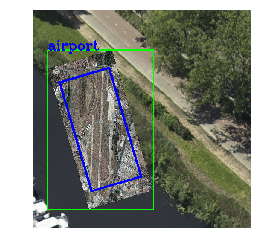

In [28]:
# get all images containing given categories, select one at random
import sys
sys.path.append('D:\API\cocoapi\PythonAPI')  # 你下载的 cocoapi 所在路径
import skimage.io as io
from pycocotools.coco import COCO   # 载入 cocoz
%matplotlib inline
coco=COCO("./aug/annos_rscup_airport.json")
catIds = coco.getCatIds(catNms=['airport'])
print(catIds)
imgIds = coco.getImgIds(catIds=catIds)
# imgIds = coco.getImgIds(imgIds=[335328])
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
I = io.imread('./aug/airport/'+img['file_name'])
plt.imshow(I)
plt.axis('off')
print(img)
annIds = coco.getAnnIds(imgIds=[img['id']], iscrowd=None)
print(len(annIds))
anns = coco.loadAnns(annIds)
print(anns)
for ann in anns:
    bbox = ann['bbox']
    poly = np.array(ann["segmentation"][0]).reshape(4,2)
    x = [int(x) for x in bbox]
    cv2.rectangle(I, (x[0],x[1]), (x[0]+x[2],x[1]+x[3]), (0,255,0), 2)
    cv2.polylines(I, np.array([poly], np.int32), 1, (0, 0, 255), 3)
    #cv2.fillPoly(I, np.array([poly], np.int32),(0.,255,0) )
    cv2.putText(I, CLASS[ann['category_id']], (x[0],x[1]), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
plt.imshow(I)
#coco.showAnns(anns)

### aug helipad

In [50]:
CLASS=['tennis-court', 'container-crane', 'storage-tank', 'baseball-diamond', 'plane', 'ground-track-field', 'helicopter', 'airport', 'harbor', 'ship', 'large-vehicle', 'swimming-pool', 'soccer-ball-field', 'roundabout', 'basketball-court', 'bridge', 'small-vehicle', 'helipad']
coco=COCO("/home/xfr/rssid/data/annotation/annos_rscup_train.json")
import mmcv
ret = {x:[] for x in CLASS}
imgIds = coco.getImgIds()
info = {}
for imgid in tqdm(imgIds):
    img = coco.loadImgs(imgid)[0]
    origin_img = cv2.imread("/home/xfr/rssid/data/train/images/"+img['file_name'])
    origin_name = img['file_name'].split(".")[0]
    annIds = coco.getAnnIds(imgIds=[imgid], iscrowd=None)
    anns = coco.loadAnns(annIds)
    count = 0
    for ann in anns:
        cls = CLASS[ann['category_id']]
        if(cls == "helipad"):
            file_name ="{}_count_{}".format(origin_name, count)+".jpg"
            count += 1
            info[file_name] = {}
            xmin, ymin, w, h = ann["bbox"]
            poly = np.array(ann["segmentation"][0]).reshape(4,2)
            poly -= np.array([xmin, ymin])
            expand_factor = min(0.15, xmin/w, ymin/h)
            poly += np.array([expand_factor*w, expand_factor*h])
            xmin = xmin-expand_factor*w
            ymin = ymin- expand_factor*h
            xmax = xmin+(1+expand_factor*2)*w
            ymax = ymin+(1+expand_factor*2)*h
            info[file_name]["bbox"] = [0, 0, xmax-xmin, ymax - ymin]
            sub_img = origin_img[int(ymin):int(ymax), int(xmin):int(xmax),:]
            info[file_name]["seg"] = poly
            cv2.imwrite("/home/xfr/rssid/helipad/"+file_name, sub_img)
mmcv.dump(info,"/home/xfr/rssid/helipad.pkl")

loading annotations into memory...
Done (t=2.16s)
creating index...
index created!


In [164]:
def merge_helipad(materials, objects, info):
    source_img = np.random.choice(materials, 1)[0]
    source_path = source + source_img
    back = cv2.imread(source_path)
    target = back.copy()
    H, W,_ = back.shape
    poly_list = []
    box_list = []
    for i in range(np.random.randint(1,5)):
        area = random.uniform(0.005, 0.02)*(H*W)
        des_img = np.random.choice(objects, 1)[0]
        des_path = des+des_img
        obj = cv2.imread(des_path)
        obj = aug_roi(obj)
        h,w,_ = obj.shape
        poly = copy.deepcopy(info[des_img]["seg"])
        obj_w = w
        obj_h = h
        img, poly, boxes, mask = RandomRotate(obj, poly, [0,0,obj_w,obj_h])
        h, w,_ = img.shape
        max_factor = min((H-2)/h, (W-2)/w)
        scale_factor = np.sqrt(area/(h*w))
        scale_factor = min(max_factor, scale_factor)
        img, scale_factor = mmcv.imrescale(img, scale_factor, return_scale=True)
        mask = mmcv.imrescale(mask, scale_factor)
        h, w,_ = img.shape
        poly*= scale_factor
        locx = np.random.randint(0, (W-w))
        locy = np.random.randint(0, (H-h))
        poly += np.array([locx, locy])
        box = np.array([locx, locy, w, h])
        center = (int(locx+w/2),int(locy+h/2))
        back[locy:locy+h, locx:locx+w, :] = back[locy:locy+h, locx:locx+w, :]* (1-mask) + img*mask
        poly_list.append(poly)
        box_list.append(box)
#     for box, poly in zip(box_list, poly_list):
#         cv2.rectangle(back, (box[0],box[1]),(int(box[0]+box[2]), int(box[1]+box[3])),(0,0,255),2)
#         cv2.polylines(back, np.array([poly], np.int32), 1, (0, 0, 255), 3)
#     #cv2.fillPoly(back, np.array([poly], np.int32),(0.,255,0) )
#     plt.imshow(back)
#     plt.show()
    
    return back, box_list, poly_list

classname = "helipad"
source = "/home/xfr/rssid/pre/"
des = "/home/xfr/rssid/{}/".format(classname)
info = mmcv.load("/home/xfr/rssid/{}.pkl".format(classname))
materials = os.listdir("/home/xfr/rssid/pre")
objects = list(info.keys())

info2 = {
    "description": "rscup",
    "url": "http://cocodataset.org",
    "version": "1.0",
    "year": 2014,
    "contributor": "COCO Consortium",
    "date_created": "2017/09/01"
  }
license = [{ "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/", "id": 1, "name": "Attribution-NonCommercial-ShareAlike License"} ]
categories = []
for cls in CLASS:
    category = { "id" : class_to_ind[cls], "name" : cls, "supercategory" : "object",}
    categories.append(category)
print(categories)
annotations = {"info": info2, "images": [], "annotations": [], "categories":categories, "license":license}
obj_id = 0
ID = 0
for i in tqdm(range(1500)):
    img, box_list, poly_list = merge_helipad(materials, objects, info)
    H, W, _, = img.shape
    filename = "{}.jpg".format(ID)
    image = { "license": 1,
                  "file_name": filename,
                  "coco_url": "xxx",
                  "height": H,
                  "width": W,
                  "date_captured": "2019-06-25",
                  "flickr_url": "xxx",
                  "id": ID
                }
   
    annotations["images"].append(image)
    cv2.imwrite("./rscup/aug/{}/".format(classname)+filename, img)
    for box, poly in zip(box_list, poly_list):
        xmin, ymin, w, h = box
        area = cv2.contourArea(np.array(np.array([poly], np.int32)))
        poly = poly.flatten()
        annotation = {"id" : obj_id, 
                    "image_id" : ID, 
                    "category_id" : class_to_ind[classname], 
                    "segmentation" : [poly], 
                   "area" :  area, 
                   "bbox" : [xmin, ymin, w, h], 
                   "iscrowd" : 0,
                }
        obj_id += 1
        annotations["annotations"].append(annotation)
    ID += 1
with open('./rscup/aug/annos_rscup_{}'.format(classname)+'.json', 'w') as json_file:
    json.dump(annotations, json_file, cls=MyEncoder)

[{'id': 0, 'name': 'tennis-court', 'supercategory': 'object'}, {'id': 1, 'name': 'container-crane', 'supercategory': 'object'}, {'id': 2, 'name': 'storage-tank', 'supercategory': 'object'}, {'id': 3, 'name': 'baseball-diamond', 'supercategory': 'object'}, {'id': 4, 'name': 'plane', 'supercategory': 'object'}, {'id': 5, 'name': 'ground-track-field', 'supercategory': 'object'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'object'}, {'id': 7, 'name': 'airport', 'supercategory': 'object'}, {'id': 8, 'name': 'harbor', 'supercategory': 'object'}, {'id': 9, 'name': 'ship', 'supercategory': 'object'}, {'id': 10, 'name': 'large-vehicle', 'supercategory': 'object'}, {'id': 11, 'name': 'swimming-pool', 'supercategory': 'object'}, {'id': 12, 'name': 'soccer-ball-field', 'supercategory': 'object'}, {'id': 13, 'name': 'roundabout', 'supercategory': 'object'}, {'id': 14, 'name': 'basketball-court', 'supercategory': 'object'}, {'id': 15, 'name': 'bridge', 'supercategory': 'object'}, {'id': 16, 'n

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[1]
{'license': 1, 'file_name': '490.jpg', 'coco_url': 'xxx', 'height': 511, 'width': 511, 'date_captured': '2019-06-25', 'flickr_url': 'xxx', 'id': 490}
1
[{'id': 726, 'image_id': 490, 'category_id': 1, 'segmentation': [[325.2679851591494, 259.47834509348445, 313.9845905060107, 254.1936890796159, 342.0928922883434, 206.31997525711682, 350.61797467334617, 211.46592568704423]], 'area': 615.0, 'bbox': [298, 197, 68, 73], 'iscrowd': 0}]


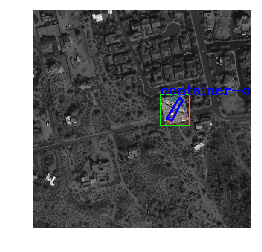

In [65]:
# get all images containing given categories, select one at random
import sys
sys.path.append('D:\API\cocoapi\PythonAPI')  # 你下载的 cocoapi 所在路径
import skimage.io as io
from pycocotools.coco import COCO   # 载入 cocoz
%matplotlib inline
coco=COCO("./rscup/aug/annos_rscup_container-crane.json")
catIds = coco.getCatIds(catNms=['container-crane'])
print(catIds)
imgIds = coco.getImgIds(catIds=catIds)
# imgIds = coco.getImgIds(imgIds=[335328])
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
I = io.imread('./rscup/aug/container-crane/'+img['file_name'])
plt.imshow(I)
plt.axis('off')
print(img)
annIds = coco.getAnnIds(imgIds=[img['id']], iscrowd=None)
print(len(annIds))
anns = coco.loadAnns(annIds)
print(anns)
for ann in anns:
    bbox = ann['bbox']
    poly = np.array(ann["segmentation"][0]).reshape(4,2)
    x = [int(x) for x in bbox]
    cv2.rectangle(I, (x[0],x[1]), (x[0]+x[2],x[1]+x[3]), (0,255,0), 2)
    cv2.polylines(I, np.array([poly], np.int32), 1, (0, 0, 255), 3)
    #cv2.fillPoly(I, np.array([poly], np.int32),(0.,255,0) )
    cv2.putText(I, CLASS[ann['category_id']], (x[0],x[1]), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
plt.imshow(I)
#coco.showAnns(anns)

### aug container crane

In [174]:
def generate_objects(classname):
    CLASS=['tennis-court', 'container-crane', 'storage-tank', 'baseball-diamond', 'plane', 'ground-track-field', 'helicopter', 'airport', 'harbor', 'ship', 'large-vehicle', 'swimming-pool', 'soccer-ball-field', 'roundabout', 'basketball-court', 'bridge', 'small-vehicle', 'helipad']
    coco=COCO("/home/xfr/rssid/data/annotation/annos_rscup_train.json")
    save_dir = "/home/xfr/rssid/{}/".format(classname)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    imgIds = coco.getImgIds()
    info = {}
    for imgid in tqdm(imgIds):
        img = coco.loadImgs(imgid)[0]
        origin_img = cv2.imread("/home/xfr/rssid/data/train/images/"+img['file_name'])
        origin_name = img['file_name'].split(".")[0]
        annIds = coco.getAnnIds(imgIds=[imgid], iscrowd=None)
        anns = coco.loadAnns(annIds)
        count = 0
        for ann in anns:
            cls = CLASS[ann['category_id']]
            if(cls == classname):
                file_name ="{}_count_{}".format(origin_name, count)+".jpg"
                count += 1
                info[file_name] = {}
                xmin, ymin, w, h = ann["bbox"]
                poly = np.array(ann["segmentation"][0]).reshape(4,2)
                poly -= np.array([xmin, ymin])
                expand_factor = min(0.15, xmin/w, ymin/h)
                poly += np.array([expand_factor*w, expand_factor*h])
                xmin = xmin-expand_factor*w
                ymin = ymin- expand_factor*h
                xmax = xmin+(1+expand_factor*2)*w
                ymax = ymin+(1+expand_factor*2)*h
                info[file_name]["bbox"] = [0, 0, xmax-xmin, ymax - ymin]
                sub_img = origin_img[int(ymin):int(ymax), int(xmin):int(xmax),:]
                info[file_name]["seg"] = poly
                cv2.imwrite("/home/xfr/rssid/{}/".format(classname)+file_name, sub_img)
    mmcv.dump(info,"/home/xfr/rssid/{}.pkl".format(classname))

In [175]:
generate_objects("container-crane")

loading annotations into memory...
Done (t=3.55s)
creating index...
index created!


In [55]:
def merge_object_background(materials, objects, info, source, des):
    source_img = np.random.choice(materials, 1)[0]
    source_path = source + source_img
    back = cv2.imread(source_path)
    target = back.copy()
    H, W,_ = back.shape
    poly_list = []
    box_list = []
    for i in range(np.random.randint(1,3)):
        area = random.uniform(0.01, 0.03)*(H*W)
        des_img = np.random.choice(objects, 1)[0]
        des_path = des+des_img
        print(des_path)
        obj = cv2.imread(des_path)
        obj = aug_roi(obj)
        h,w,_ = obj.shape
        poly = copy.deepcopy(info[des_img]["seg"])
        obj_w = w
        obj_h = h
        img, poly, boxes, mask = RandomRotate(obj, poly, [0,0,obj_w,obj_h])
        h, w,_ = img.shape
        max_factor = min((H-2)/h, (W-2)/w)
        scale_factor = np.sqrt(area/(h*w))
        scale_factor = min(max_factor, scale_factor)
        img, scale_factor = mmcv.imrescale(img, scale_factor, return_scale=True)
        mask = mmcv.imrescale(mask, scale_factor)
        h, w,_ = img.shape
        poly*= scale_factor
        locx = np.random.randint(0, (W-w))
        locy = np.random.randint(0, (H-h))
        poly += np.array([locx, locy])
        box = np.array([locx, locy, w, h])
        center = (int(locx+w/2),int(locy+h/2))
        back[locy:locy+h, locx:locx+w, :] = back[locy:locy+h, locx:locx+w, :]* (1-mask) + img*mask
        poly_list.append(poly)
        box_list.append(box)
    for box, poly in zip(box_list, poly_list):
        cv2.rectangle(back, (box[0],box[1]),(int(box[0]+box[2]), int(box[1]+box[3])),(0,0,255),2)
        cv2.polylines(back, np.array([poly], np.int32), 1, (0, 0, 255), 3)
    #cv2.fillPoly(back, np.array([poly], np.int32),(0.,255,0) )
#     plt.imshow(back)
#     plt.show()
    
    return back, box_list, poly_list

def aug_with_background(classname):
    if not os.path.exists("./rscup/aug/{}/".format(classname)):
        os.makedirs("./rscup/aug/{}/".format(classname))
    source = "/home/xfr/rssid/pre/"
    des = "/home/xfr/rssid/{}/".format(classname)
    info = mmcv.load("/home/xfr/rssid/{}.pkl".format(classname))
    materials = os.listdir("/home/xfr/rssid/pre")
    objects = list(info.keys())

    info2 = {
        "description": "rscup",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2014,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
      }
    license = [{ "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/", "id": 1, "name": "Attribution-NonCommercial-ShareAlike License"} ]
    categories = []
    for cls in CLASS:
        category = { "id" : class_to_ind[cls], "name" : cls, "supercategory" : "object",}
        categories.append(category)
    print(categories)
    annotations = {"info": info2, "images": [], "annotations": [], "categories":categories, "license":license}
    obj_id = 0
    ID = 0
    for i in tqdm(range(500)):
        img, box_list, poly_list = merge_object_background(materials, objects, info, source, des)
        H, W, _, = img.shape
        filename = "{}.jpg".format(ID)
        image = { "license": 1,
                      "file_name": filename,
                      "coco_url": "xxx",
                      "height": H,
                      "width": W,
                      "date_captured": "2019-06-25",
                      "flickr_url": "xxx",
                      "id": ID
                    }

        annotations["images"].append(image)
        cv2.imwrite("./rscup/aug/{}/".format(classname)+filename, img)
        for box, poly in zip(box_list, poly_list):
            xmin, ymin, w, h = box
            area = cv2.contourArea(np.array(np.array([poly], np.int32)))
            poly = poly.flatten()
            annotation = {"id" : obj_id, 
                        "image_id" : ID, 
                        "category_id" : class_to_ind[classname], 
                        "segmentation" : [poly], 
                       "area" :  area, 
                       "bbox" : [xmin, ymin, w, h], 
                       "iscrowd" : 0,
                    }
            obj_id += 1
            annotations["annotations"].append(annotation)
        ID += 1
    with open('./rscup/aug/annos_rscup_{}'.format(classname)+'.json', 'w') as json_file:
        json.dump(annotations, json_file, cls=MyEncoder)

In [56]:
aug_with_background("container-crane")

[{'id': 0, 'name': 'tennis-court', 'supercategory': 'object'}, {'id': 1, 'name': 'container-crane', 'supercategory': 'object'}, {'id': 2, 'name': 'storage-tank', 'supercategory': 'object'}, {'id': 3, 'name': 'baseball-diamond', 'supercategory': 'object'}, {'id': 4, 'name': 'plane', 'supercategory': 'object'}, {'id': 5, 'name': 'ground-track-field', 'supercategory': 'object'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'object'}, {'id': 7, 'name': 'airport', 'supercategory': 'object'}, {'id': 8, 'name': 'harbor', 'supercategory': 'object'}, {'id': 9, 'name': 'ship', 'supercategory': 'object'}, {'id': 10, 'name': 'large-vehicle', 'supercategory': 'object'}, {'id': 11, 'name': 'swimming-pool', 'supercategory': 'object'}, {'id': 12, 'name': 'soccer-ball-field', 'supercategory': 'object'}, {'id': 13, 'name': 'roundabout', 'supercategory': 'object'}, {'id': 14, 'name': 'basketball-court', 'supercategory': 'object'}, {'id': 15, 'name': 'bridge', 'supercategory': 'object'}, {'id': 16, 'n

/home/xfr/rssid/container-crane/P2732_count_58.jpg
/home/xfr/rssid/container-crane/P2761_count_10.jpg
/home/xfr/rssid/container-crane/P2761_count_4.jpg
/home/xfr/rssid/container-crane/P2642_count_16.jpg
/home/xfr/rssid/container-crane/P2732_count_68.jpg
/home/xfr/rssid/container-crane/P2732_count_68.jpg
/home/xfr/rssid/container-crane/P2732_count_12.jpg
/home/xfr/rssid/container-crane/P4076_count_4.jpg
/home/xfr/rssid/container-crane/P2732_count_55.jpg
/home/xfr/rssid/container-crane/P2732_count_42.jpg
/home/xfr/rssid/container-crane/P5593_count_7.jpg
/home/xfr/rssid/container-crane/P2668_count_6.jpg
/home/xfr/rssid/container-crane/P2668_count_3.jpg
/home/xfr/rssid/container-crane/P2732_count_57.jpg
/home/xfr/rssid/container-crane/P3536_count_31.jpg
/home/xfr/rssid/container-crane/P2642_count_4.jpg
/home/xfr/rssid/container-crane/P2732_count_21.jpg
/home/xfr/rssid/container-crane/P3536_count_5.jpg
/home/xfr/rssid/container-crane/P9847_count_1.jpg
/home/xfr/rssid/container-crane/P2692_c

/home/xfr/rssid/container-crane/P2761_count_1.jpg
/home/xfr/rssid/container-crane/P2642_count_9.jpg
/home/xfr/rssid/container-crane/P2668_count_6.jpg
/home/xfr/rssid/container-crane/P2732_count_0.jpg
/home/xfr/rssid/container-crane/P2692_count_7.jpg
/home/xfr/rssid/container-crane/P2732_count_16.jpg
/home/xfr/rssid/container-crane/P3536_count_32.jpg
/home/xfr/rssid/container-crane/P2642_count_11.jpg
/home/xfr/rssid/container-crane/P2732_count_48.jpg
/home/xfr/rssid/container-crane/P2732_count_72.jpg
/home/xfr/rssid/container-crane/P9847_count_23.jpg
/home/xfr/rssid/container-crane/P1228_count_9.jpg
/home/xfr/rssid/container-crane/P3536_count_31.jpg
/home/xfr/rssid/container-crane/P2732_count_51.jpg
/home/xfr/rssid/container-crane/P9847_count_20.jpg
/home/xfr/rssid/container-crane/P3536_count_41.jpg
/home/xfr/rssid/container-crane/P2732_count_32.jpg
/home/xfr/rssid/container-crane/P2642_count_15.jpg
/home/xfr/rssid/container-crane/P4851_count_1.jpg
/home/xfr/rssid/container-crane/P2732_

/home/xfr/rssid/container-crane/P1228_count_4.jpg
/home/xfr/rssid/container-crane/P2732_count_77.jpg
/home/xfr/rssid/container-crane/P4076_count_5.jpg
/home/xfr/rssid/container-crane/P9847_count_11.jpg
/home/xfr/rssid/container-crane/P4076_count_6.jpg
/home/xfr/rssid/container-crane/P2732_count_62.jpg
/home/xfr/rssid/container-crane/P3536_count_50.jpg
/home/xfr/rssid/container-crane/P2642_count_15.jpg
/home/xfr/rssid/container-crane/P2732_count_66.jpg
/home/xfr/rssid/container-crane/P9847_count_9.jpg
/home/xfr/rssid/container-crane/P5593_count_12.jpg
/home/xfr/rssid/container-crane/P1228_count_7.jpg
/home/xfr/rssid/container-crane/P3536_count_43.jpg
/home/xfr/rssid/container-crane/P2732_count_75.jpg
/home/xfr/rssid/container-crane/P2732_count_15.jpg
/home/xfr/rssid/container-crane/P2668_count_1.jpg
/home/xfr/rssid/container-crane/P5593_count_7.jpg
/home/xfr/rssid/container-crane/P2692_count_0.jpg
/home/xfr/rssid/container-crane/P5593_count_2.jpg
/home/xfr/rssid/container-crane/P2732_co

/home/xfr/rssid/container-crane/P2692_count_2.jpg
/home/xfr/rssid/container-crane/P3536_count_23.jpg
/home/xfr/rssid/container-crane/P2732_count_57.jpg
/home/xfr/rssid/container-crane/P3536_count_43.jpg
/home/xfr/rssid/container-crane/P2761_count_10.jpg
/home/xfr/rssid/container-crane/P2692_count_8.jpg
/home/xfr/rssid/container-crane/P1228_count_2.jpg
/home/xfr/rssid/container-crane/P2631_count_0.jpg
/home/xfr/rssid/container-crane/P3536_count_37.jpg
/home/xfr/rssid/container-crane/P2732_count_2.jpg
/home/xfr/rssid/container-crane/P2642_count_2.jpg
/home/xfr/rssid/container-crane/P2732_count_62.jpg
/home/xfr/rssid/container-crane/P9847_count_22.jpg
/home/xfr/rssid/container-crane/P4076_count_5.jpg
/home/xfr/rssid/container-crane/P3536_count_38.jpg
/home/xfr/rssid/container-crane/P9847_count_5.jpg
/home/xfr/rssid/container-crane/P3536_count_2.jpg
/home/xfr/rssid/container-crane/P3536_count_40.jpg
/home/xfr/rssid/container-crane/P2692_count_6.jpg
/home/xfr/rssid/container-crane/P2732_cou

/home/xfr/rssid/container-crane/P3536_count_27.jpg
/home/xfr/rssid/container-crane/P2732_count_79.jpg
/home/xfr/rssid/container-crane/P5593_count_8.jpg
/home/xfr/rssid/container-crane/P2732_count_44.jpg
/home/xfr/rssid/container-crane/P2732_count_42.jpg
/home/xfr/rssid/container-crane/P2732_count_40.jpg
/home/xfr/rssid/container-crane/P2732_count_23.jpg
/home/xfr/rssid/container-crane/P9847_count_1.jpg
/home/xfr/rssid/container-crane/P1228_count_10.jpg
/home/xfr/rssid/container-crane/P2761_count_1.jpg
/home/xfr/rssid/container-crane/P2732_count_49.jpg
/home/xfr/rssid/container-crane/P2761_count_2.jpg
/home/xfr/rssid/container-crane/P3536_count_44.jpg
/home/xfr/rssid/container-crane/P2761_count_3.jpg
/home/xfr/rssid/container-crane/P2732_count_41.jpg
/home/xfr/rssid/container-crane/P2732_count_78.jpg
/home/xfr/rssid/container-crane/P4076_count_3.jpg
/home/xfr/rssid/container-crane/P5593_count_8.jpg
/home/xfr/rssid/container-crane/P2732_count_60.jpg
/home/xfr/rssid/container-crane/P4076_

## noise aug

In [235]:
def noise_generate(datadir, phase):
    
    

In [236]:
noise_generate("/home/xfr/rssid/pre/", "noise")

[{'id': 0, 'name': 'tennis-court', 'supercategory': 'object'}, {'id': 1, 'name': 'container-crane', 'supercategory': 'object'}, {'id': 2, 'name': 'storage-tank', 'supercategory': 'object'}, {'id': 3, 'name': 'baseball-diamond', 'supercategory': 'object'}, {'id': 4, 'name': 'plane', 'supercategory': 'object'}, {'id': 5, 'name': 'ground-track-field', 'supercategory': 'object'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'object'}, {'id': 7, 'name': 'airport', 'supercategory': 'object'}, {'id': 8, 'name': 'harbor', 'supercategory': 'object'}, {'id': 9, 'name': 'ship', 'supercategory': 'object'}, {'id': 10, 'name': 'large-vehicle', 'supercategory': 'object'}, {'id': 11, 'name': 'swimming-pool', 'supercategory': 'object'}, {'id': 12, 'name': 'soccer-ball-field', 'supercategory': 'object'}, {'id': 13, 'name': 'roundabout', 'supercategory': 'object'}, {'id': 14, 'name': 'basketball-court', 'supercategory': 'object'}, {'id': 15, 'name': 'bridge', 'supercategory': 'object'}, {'id': 16, 'n

totol number 75532


In [222]:
os.listdir("/home/xfr/rssid/pre/")

['P5203_1_17056.0_2912.0_part2524.jpg',
 'P11054_1_4576.0_17472.0_part772.jpg',
 'P8587_1_4576.0_416.0_part49.jpg',
 'P1540_1_3328.0_2496.0_part76.jpg',
 'P1489_1_1664.0_1248.0_part46.jpg',
 'P1599_1_2912.0_1664.0_part79.jpg',
 'P3536_1_9984.0_9152.0_part1276.jpg',
 'P3536_1_2080.0_9568.0_part271.jpg',
 'P9847_1_4992.0_25792.0_part857.jpg',
 'P5203_1_14976.0_23296.0_part2292.jpg',
 'P2642_1_5824.0_5038.0_part97.jpg',
 'P1336_1_2496.0_832.0_part44.jpg',
 'P9018_1_3744.0_3744.0_part107.jpg',
 'P5203_1_23296.0_1248.0_part3394.jpg',
 'P1221_1_3487.0_2080.0_part80.jpg',
 'P9847_1_3328.0_2912.0_part539.jpg',
 'P3536_1_16224.0_12064.0_part2241.jpg',
 'P11054_1_20384.0_6656.0_part3235.jpg',
 'P1375_1_416.0_2496.0_part17.jpg',
 'P3536_1_3744.0_2496.0_part467.jpg',
 'P1205_1_2496.0_2912.0_part64.jpg',
 'P2751_1_416.0_2912.0_part13.jpg',
 'P11054_1_2912.0_21216.0_part517.jpg',
 'P9847_0.5_6240.0_12896.0_part495.jpg',
 'P1470_1_1664.0_2080.0_part27.jpg',
 'P2359_1_1516.0_832.0_part23.jpg',
 'P3536